# Modeling 07

Idea:
- build features up to lag 52 (one year)
- select 50, 100 most informative features (as per mutual information with target) to build a linear model
- more sophisticated feature selection schemes may be used if the mutual information approach does not yield the expected improvements

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import sklearn
from os.path import join

In [37]:
from sklearn.feature_selection import mutual_info_regression
from sklearn.linear_model import Lasso, Ridge
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_validate, TimeSeriesSplit, GridSearchCV
from xgboost import XGBRegressor

In [3]:
cd ..

C:\Users\Anders\Documents\data-science-projects\dss-diseasespread


In [4]:
from src.features.build_lagged_features import add_lagged_features

In [5]:
mpl.rcParams.update({
    'figure.autolayout': True,
    'figure.dpi': 150
})
sns.set()

In [6]:
RAW_PATH = 'data/raw'

## Reading the data

In [7]:
train_features_o = pd.read_csv(join(RAW_PATH, 'dengue_features_train.csv')) 
test_features_o = pd.read_csv(join(RAW_PATH, 'dengue_features_test.csv')) 
train_labels = pd.read_csv(join(RAW_PATH, 'dengue_labels_train.csv'))

## Feature Engineering

Concatenate training and testing data to create lagged features as test data is in the immediate 
future of the training data for each of the cities

In [8]:
train_features_sj = train_features_o[train_features_o['city'] == 'sj'].drop('city', axis = 1)
train_features_iq = train_features_o[train_features_o['city'] == 'iq'].drop('city', axis = 1)

test_features_sj = test_features_o[test_features_o['city'] == 'sj'].drop('city', axis = 1)
test_features_iq = test_features_o[test_features_o['city'] == 'iq'].drop('city', axis = 1)

features_sj = pd.concat([train_features_sj, test_features_sj])
features_iq = pd.concat([train_features_iq, test_features_iq])

In [9]:
len(test_features_sj)

260

In [10]:
len(test_features_iq)

156

Function used in previous notebook (`apoirel_exploration_02`) to build lagged features

In [11]:
def make_dataset(features):
    features = (features
        .drop( # correlated features
            ['reanalysis_sat_precip_amt_mm', 'reanalysis_dew_point_temp_k', 
             'reanalysis_air_temp_k', 'reanalysis_tdtr_k'],
            axis = 1
        )
        .fillna(method = 'backfill')
        .drop( # unused features
            ['year', 'weekofyear','week_start_date'], 
            axis = 1
        )
    )
    ts_features = list(features.loc[:, 'ndvi_ne' :].columns.values)

    features = add_lagged_features(
        features, 52, ts_features)
    
    return features

In [12]:
features_sj = make_dataset(features_sj)
features_iq = make_dataset(features_iq)

Seperate the testing features from training

In [13]:
test_features_sj = features_sj.iloc[-260:, :]
test_features_iq = features_iq.iloc[-156:, :]

Remove the first year of values (number of NAs is too high due to unavailability of 
lagged features)

In [14]:
train_features_sj = features_sj.iloc[52:-260,:]
train_features_iq = features_iq.iloc[52:-156,:]

In [15]:
train_labels_iq = train_labels[
    train_labels['city'] == 'iq']['total_cases'].astype('float')[52:]
train_labels_sj = train_labels[
    train_labels['city'] == 'sj']['total_cases'].astype('float')[52:]

## Features selection

From research papers I've read, local particularities have a large bearing on the impact of 
climactic factors on dengue outbreaks, so it makes sense to select features seperately 
for each city

### San Juan

In [16]:
sj_corrs = train_features_sj.corrwith(train_labels_sj).abs().sort_values()

In [17]:
train_features_sj = train_features_sj[list(sj_corrs.iloc[-100:].index)]
test_features_sj = test_features_sj[list(sj_corrs.iloc[-100:].index)]

### Iquitos

In [18]:
iq_corrs = train_features_iq.corrwith(train_labels_iq).abs().sort_values()

In [19]:
train_features_iq = train_features_iq[list(iq_corrs.iloc[-100:].index)]
test_features_iq = test_features_iq[list(iq_corrs.iloc[-100:].index)]

## Modeling

### San Juan

#### Linear

In [20]:
model_sj = Pipeline([
    ('scale', StandardScaler()),
    ('lasso', Ridge(10000))
])
cv_res_sj = cross_validate(
    estimator = model_sj,
    X = train_features_sj,
    y = train_labels_sj,
    cv = TimeSeriesSplit(n_splits = 10),
    scoring = 'neg_mean_absolute_error',
    n_jobs = -1
)
sj_score = np.mean(cv_res_sj['test_score'])
sj_score

-31.636291923494646

##### Visualization

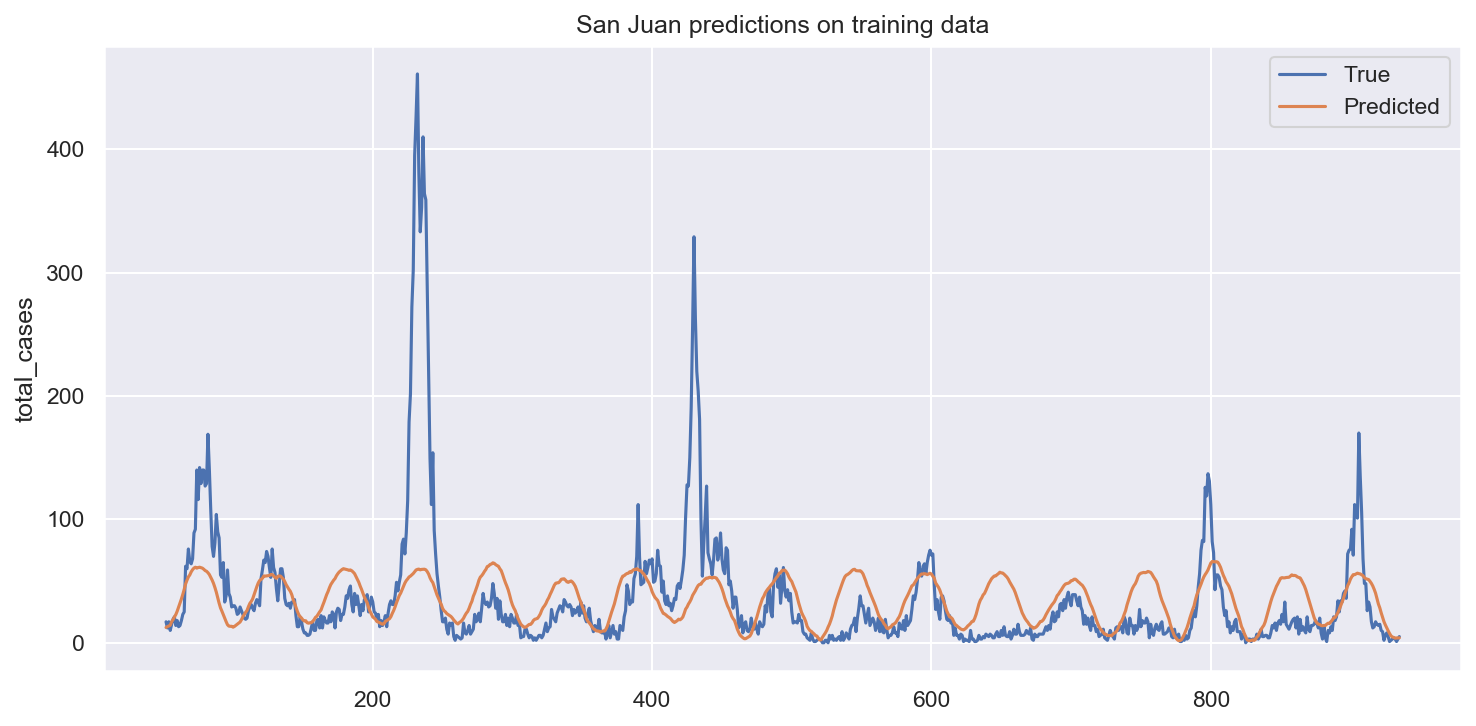

In [21]:
model_sj.fit(train_features_sj, train_labels_sj)
y_val_sj = model_sj.predict(train_features_sj).flatten()

fig, ax = plt.subplots(figsize = (10, 5))
sns.lineplot(y = train_labels_sj, x = train_features_sj.index.values, ax = ax)
sns.lineplot(y = y_val_sj, x = train_features_sj.index.values, ax = ax)
ax.set(title = 'San Juan predictions on training data')
ax.legend(['True', 'Predicted'])

### Gradient boosting

In [99]:
model_sj = XGBRegressor(
    max_depth = 10,
    learning_rate = 0.01,
    n_estimators = 200,
    reg_lambda = 1,
    
)
cv_res_sj = cross_validate(
    estimator = model_sj,
    X = train_features_sj,
    y = train_labels_sj,
    cv = TimeSeriesSplit(n_splits = 10),
    scoring = 'neg_mean_absolute_error',
    n_jobs = -1
)
sj_score = np.mean(cv_res_sj['test_score'])
sj_score

-27.536122611761094

In [100]:
np.std(cv_res_sj['test_score'])

18.450364963460753

##### Visualization

[17:08:29] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


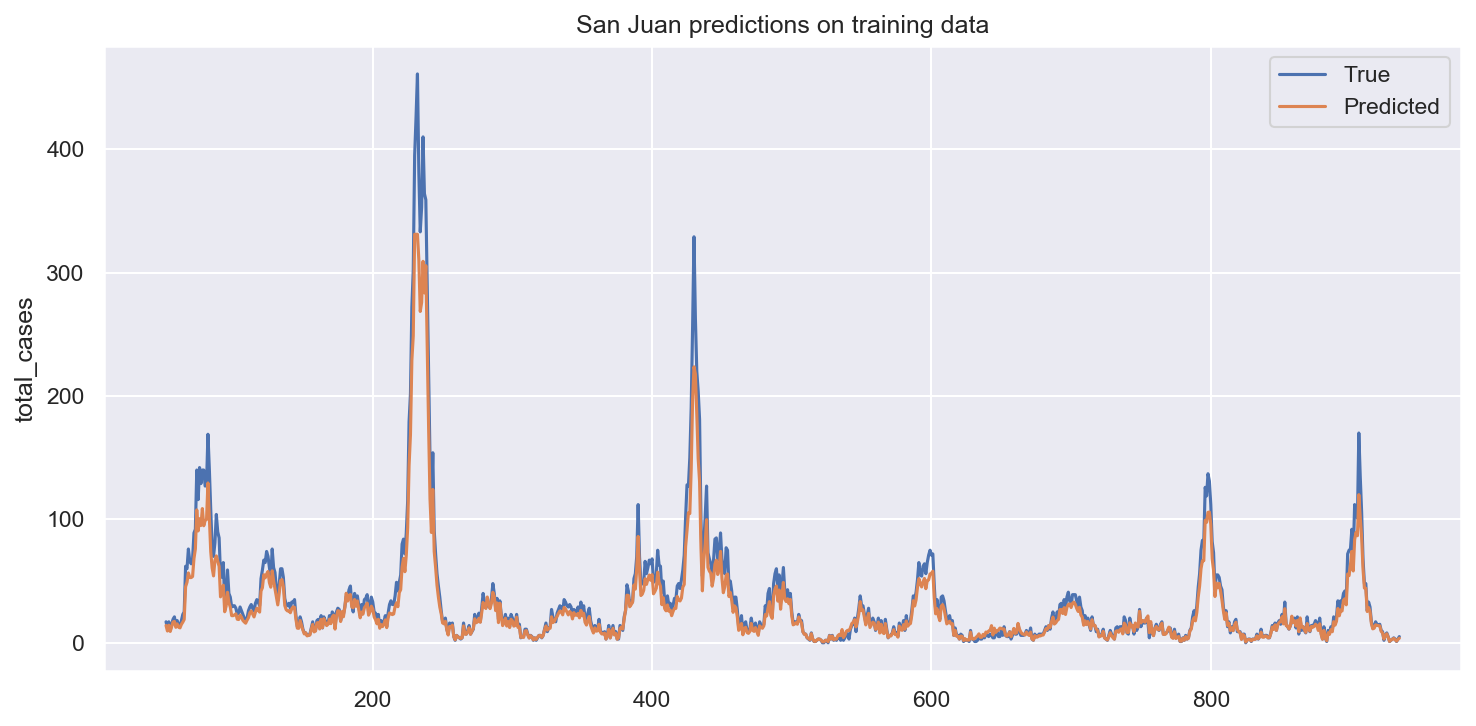

In [23]:
model_sj.fit(train_features_sj, train_labels_sj)
y_val_sj = model_sj.predict(train_features_sj).flatten()

fig, ax = plt.subplots(figsize = (10, 5))
sns.lineplot(y = train_labels_sj, x = train_features_sj.index.values, ax = ax)
sns.lineplot(y = y_val_sj, x = train_features_sj.index.values, ax = ax)
ax.set(title = 'San Juan predictions on training data')
ax.legend(['True', 'Predicted'])

This looks seriously overfitting, yet the CV score is pretty good. What's up with that?

#### Tuned gradient boosting

In [71]:
params = { 
    'learning_rate' : [0.001 , 0.01, 0.1],
    'reg_lambda' : [0.1, 1, 10],
    'max_depth': [2, 5, 8, 10],
    'n_estimators': [50, 100 , 200]
}
tuned_model_sj = GridSearchCV(
    estimator = XGBRegressor(),
    param_grid = params,
    scoring = 'neg_mean_absolute_error', 
    cv = TimeSeriesSplit(10), 
    n_jobs = -1
)

In [72]:
tuned_model_sj.fit(train_features_sj, train_labels_sj)

[17:40:01] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


GridSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=10),
             estimator=XGBRegressor(), n_jobs=-1,
             param_grid={'learning_rate': [0.001, 0.01, 0.1],
                         'max_depth': [2, 5, 8, 10],
                         'n_estimators': [50, 100, 200],
                         'reg_lambda': [0.1, 1, 10]},
             scoring='neg_mean_absolute_error')

In [73]:
tuned_model_sj.best_score_

-21.926672992706298

In [74]:
tuned_model_sj.best_params_

{'learning_rate': 0.01, 'max_depth': 2, 'n_estimators': 50, 'reg_lambda': 1}

In [97]:
cv_res_sj = cross_validate(
    estimator = tuned_model_sj.best_estimator_,
    X = train_features_sj,
    y = train_labels_sj,
    cv = TimeSeriesSplit(n_splits = 10),
    scoring = 'neg_mean_absolute_error',
    n_jobs = -1
)
sj_score = np.mean(cv_res_sj['test_score'])
sj_score

-21.926672992706298

In [98]:
np.std(cv_res_sj['test_score'])

22.71568409138517

##### Visualization

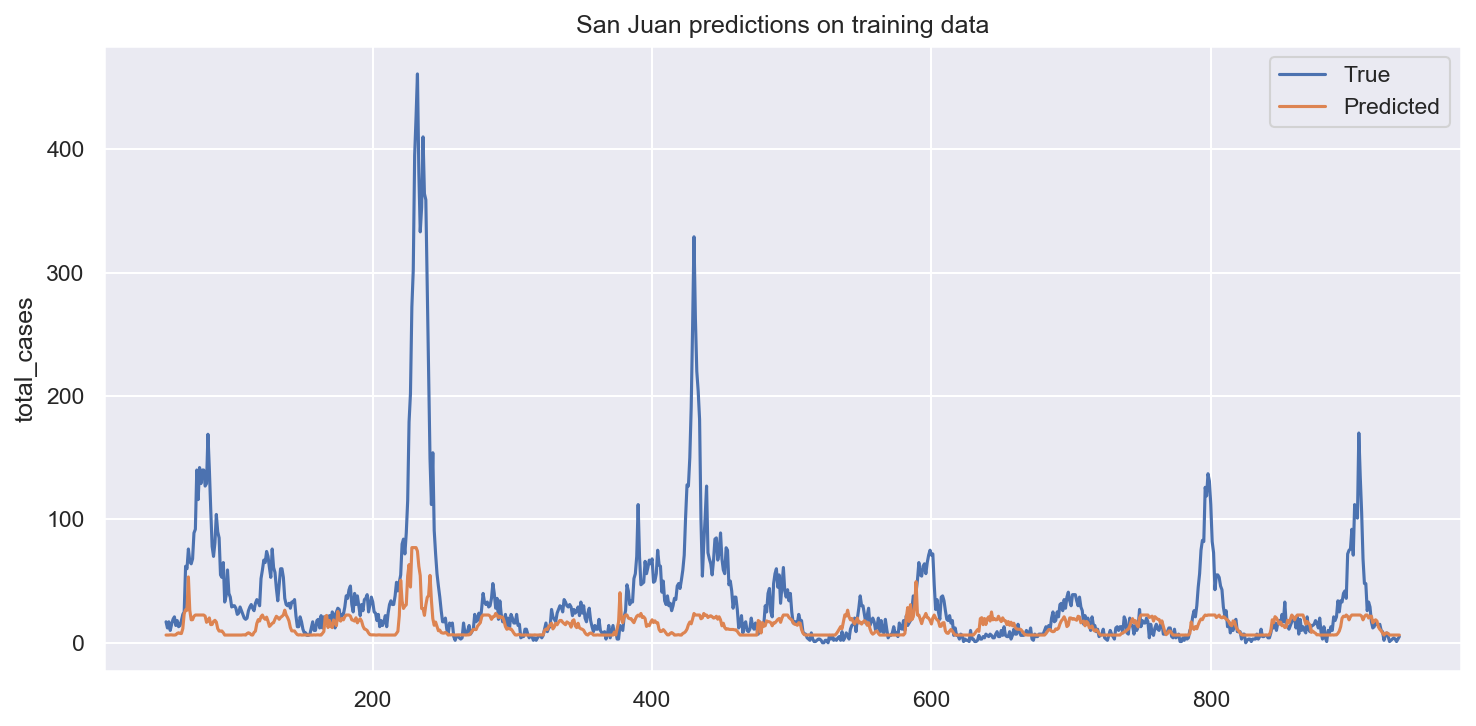

In [75]:
y_val_sj = tuned_model_sj.predict(train_features_sj).flatten()
fig, ax = plt.subplots(figsize = (10, 5))
sns.lineplot(y = train_labels_sj, x = train_features_sj.index.values, ax = ax)
sns.lineplot(y = y_val_sj, x = train_features_sj.index.values, ax = ax)
ax.set(title = 'San Juan predictions on training data')
ax.legend(['True', 'Predicted'])

### Iquitos

#### Linear model

In [24]:
model_iq = Pipeline([
    ('scale', StandardScaler()),
    ('lasso', Lasso(2))
])

In [25]:
cv_res_iq = cross_validate(
    estimator = model_iq,
    X = train_features_iq,
    y = train_labels_iq,
    cv = TimeSeriesSplit(n_splits = 10),
    scoring = 'neg_mean_absolute_error',
    n_jobs = -1
)
iq_score = np.mean(cv_res_iq['test_score'])
iq_score

-6.82235885730308

##### Visualization

In [26]:
model_iq.fit(train_features_iq, train_labels_iq)
y_val_iq = model_iq.predict(train_features_iq).flatten()

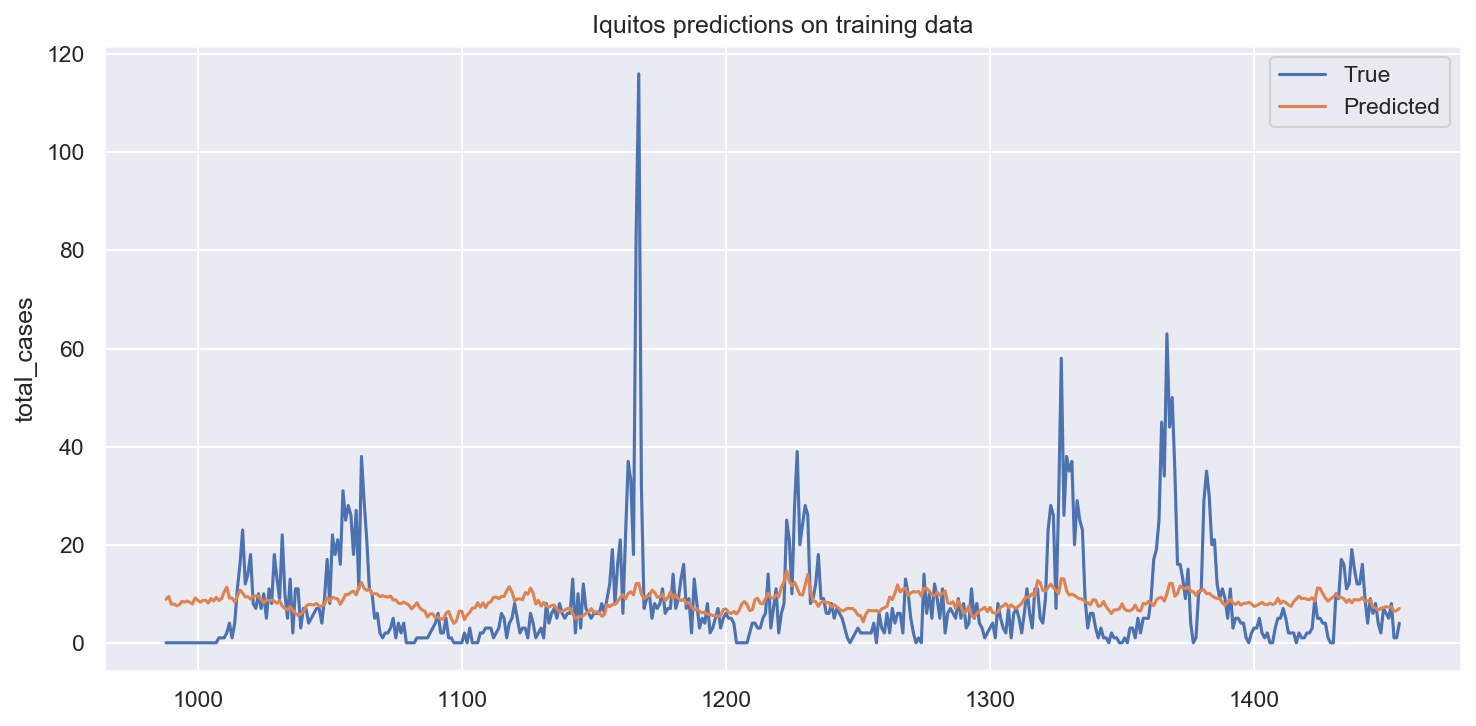

In [27]:
fig, ax = plt.subplots(figsize = (10, 5))
sns.lineplot(y = train_labels_iq, x = train_features_iq.index.values, ax = ax)
sns.lineplot(y = y_val_iq, x = train_features_iq.index.values, ax = ax)
ax.set(title = 'Iquitos predictions on training data')
ax.legend(['True', 'Predicted'])

### Gradient boosting

In [76]:
model_iq = XGBRegressor(
    max_depth = 10,
    learning_rate = 0.02,
    n_estimators = 200,
    reg_lambda = 20,
    
)
cv_res_iq = cross_validate(
    estimator = model_iq,
    X = train_features_iq,
    y = train_labels_iq,
    cv = TimeSeriesSplit(n_splits = 10),
    scoring = 'neg_mean_absolute_error',
    n_jobs = -1
)
iq_score = np.mean(cv_res_iq['test_score'])
iq_score

-6.9574255988001825

##### Visualization

[17:08:35] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


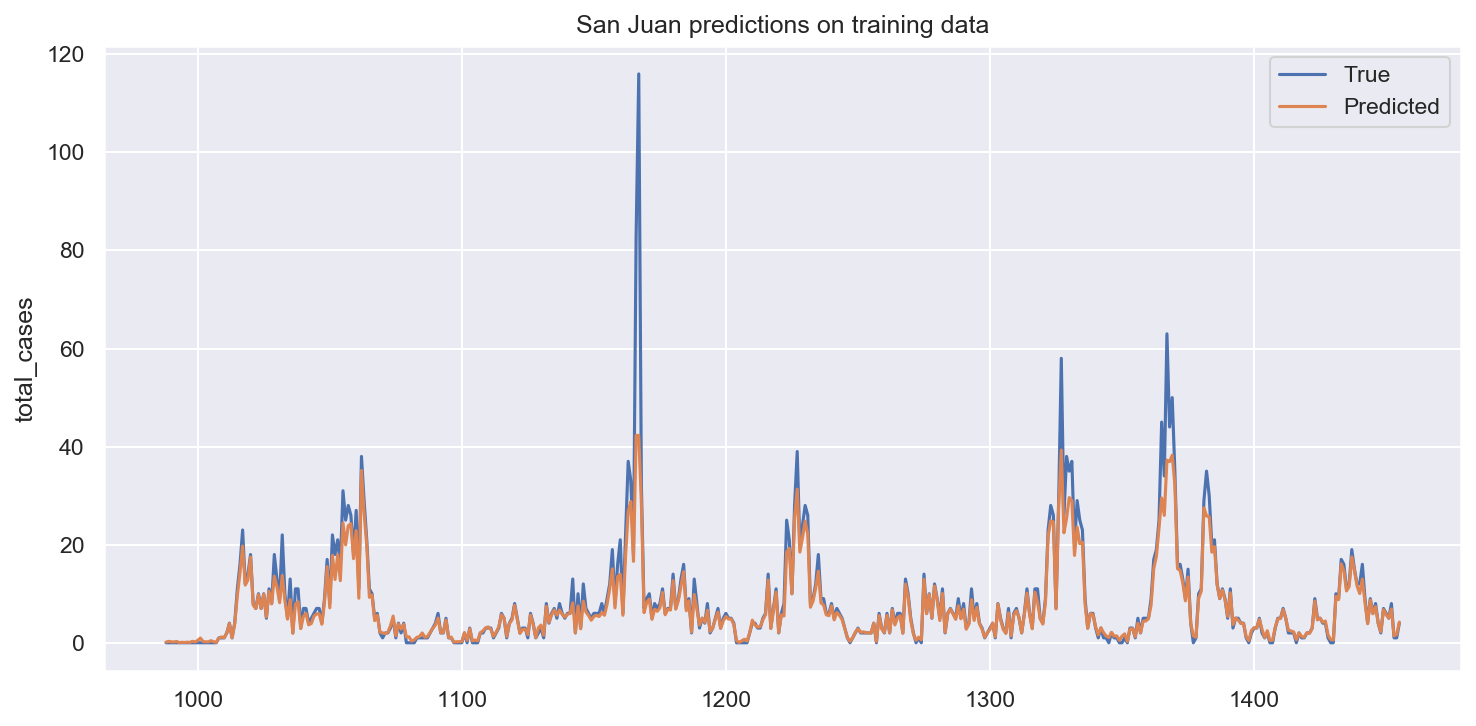

In [29]:
model_iq.fit(train_features_iq, train_labels_iq)
y_val_iq = model_iq.predict(train_features_iq).flatten()

fig, ax = plt.subplots(figsize = (10, 5))
sns.lineplot(y = train_labels_iq, x = train_features_iq.index.values, ax = ax)
sns.lineplot(y = y_val_iq, x = train_features_iq.index.values, ax = ax)
ax.set(title = 'Iquitos predictions on training data')
ax.legend(['True', 'Predicted'])

Same here, this seems to overfit a lot, yet the CV score looks good

#### Tuned gradient boosting

In [77]:
params = { 
    'learning_rate' : [0.001 , 0.01, 0.1],
    'reg_lambda' : [0.1, 1, 10],
    'max_depth': [2, 5, 8, 10],
    'n_estimators': [50, 100 , 200]
}
tuned_model_iq = GridSearchCV(
    estimator = XGBRegressor(),
    param_grid = params,
    scoring = 'neg_mean_absolute_error', 
    cv = TimeSeriesSplit(10), 
    n_jobs = -1
)

In [78]:
tuned_model_iq.fit(train_features_iq, train_labels_iq)

[17:44:03] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


GridSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=10),
             estimator=XGBRegressor(), n_jobs=-1,
             param_grid={'learning_rate': [0.001, 0.01, 0.1],
                         'max_depth': [2, 5, 8, 10],
                         'n_estimators': [50, 100, 200],
                         'reg_lambda': [0.1, 1, 10]},
             scoring='neg_mean_absolute_error')

In [79]:
tuned_model_iq.best_score_

-6.534910500333423

In [80]:
tuned_model_iq.best_params_

{'learning_rate': 0.01, 'max_depth': 2, 'n_estimators': 100, 'reg_lambda': 10}

##### Visualization

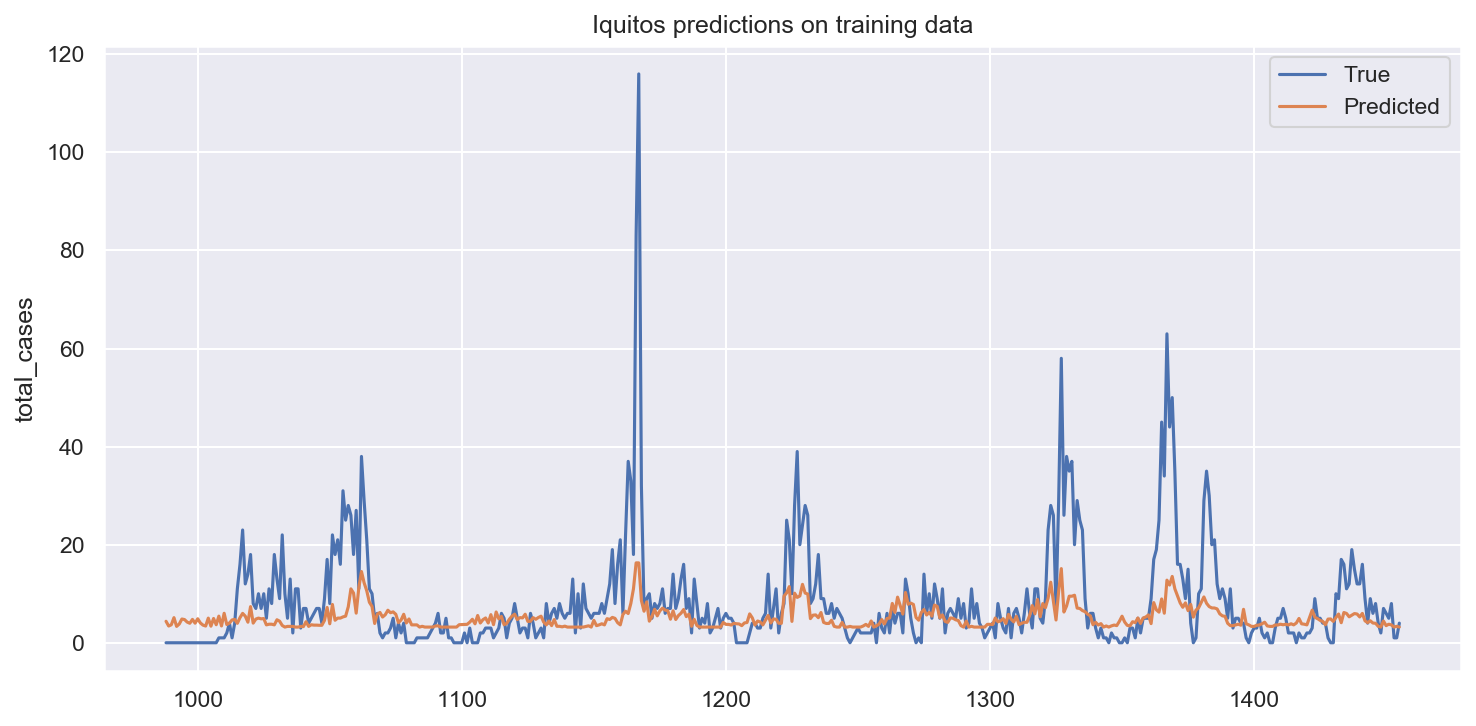

In [82]:
y_val_iq = tuned_model_iq.predict(train_features_iq).flatten()
fig, ax = plt.subplots(figsize = (10, 5))
sns.lineplot(y = train_labels_iq, x = train_features_iq.index.values, ax = ax)
sns.lineplot(y = y_val_iq, x = train_features_iq.index.values, ax = ax)
ax.set(title = 'Iquitos predictions on training data')
ax.legend(['True', 'Predicted'])

## Overall performance

In [83]:
sj_ratio = len(train_features_sj) / (len(train_features_sj) + len(train_features_iq))
iq_ratio = len(train_features_iq) / (len(train_features_sj) + len(train_features_iq))

Gradient boosting

In [84]:
sj_ratio * sj_score + iq_ratio * iq_score

-20.41272749189001

Tuned gradient boosting

In [85]:
sj_ratio * tuned_model_sj.best_score_ + iq_ratio * tuned_model_iq.best_score_

-16.598755206884917

Much better than our previous best, this warrants a submission!

## Model predictions

### XGB First pass

In [32]:
lagyear_sub = pd.read_csv(join(RAW_PATH, 'submission_format.csv'))

In [33]:
y_pred_sj = model_sj.predict(test_features_sj)
y_pred_iq = model_iq.predict(test_features_iq)

In [34]:
y_pred = np.concatenate((y_pred_sj, y_pred_iq))
lagyear_sub['total_cases'] = np.round(y_pred).astype(int)
lagyear_sub.to_csv('models/lagyear_xgb.csv', index = None)

#### Results

25.1 MAE on leaderboard, not an improvement over our best score (~24 MAE) but still our second best model overall

### Tuned XGB

In [86]:
lagyear_tuned_sub = pd.read_csv(join(RAW_PATH, 'submission_format.csv'))

In [87]:
y_pred_sj = tuned_model_sj.predict(test_features_sj)
y_pred_iq = tuned_model_iq.predict(test_features_iq)

In [88]:
y_pred = np.concatenate((y_pred_sj, y_pred_iq))
lagyear_tuned_sub['total_cases'] = np.round(y_pred).astype(int)
lagyear_tuned_sub.to_csv('models/lagyear_tuned_xgb.csv', index = None)

#### Results

29.6 MAE on leaderbpard, which is far worse than our previous bests. After examination, it seems like
the tuned model has much higher variance in error, which may help explain the poor final scores